In [1]:
import torch
import torchvision
from torchvision import transforms as T
import torchvision.transforms.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = "data"

In [3]:
dataset = torchvision.datasets.ImageFolder(data_dir, transform = T.ToTensor())

In [4]:
print(len(dataset))
print(dataset.class_to_idx)
idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}
print(idx_to_class)

515
{'checked': 0, 'other': 1, 'unchecked': 2}
{0: 'checked', 1: 'other', 2: 'unchecked'}


### Finding min-max width and height of dataset

In [5]:
max_height = 0
min_height = np.inf
max_width = 0
min_width = np.inf

labels = list()

for image, label in dataset:
    _, h, w = image.shape
    
    if h > max_height:
        max_height = h
    elif h < min_height:
        min_height = h
    
    if w > max_width:
        max_width = w
    elif w < min_width:
        min_width = w
        
    labels.append(label)

print(min_height, max_height)
print(min_width, max_width)

26 502
24 1804


Ideal image size selected = (256, 512)

### Visualising class count

In [6]:
labels = np.array(labels)
classes, counts = np.unique(labels, return_counts=True)
print(classes, counts)

[0 1 2] [222 138 155]


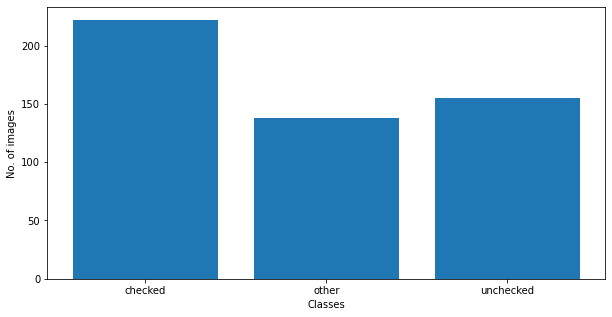

In [7]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
classes = [idx_to_class[c] for c in classes]
plt.bar(classes, counts)
 
plt.xlabel("Classes")
plt.ylabel("No. of images")
plt.show()

In [4]:
transform = T.Compose([
    T.Resize((256, 512)),
    T.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder(data_dir, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

### Finding mean and std for normalization

In [9]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = get_mean_and_std(data_loader)

print("Mean: ", mean)
print("STD: ", std)

Mean:  tensor([0.6568, 0.6760, 0.7115])
STD:  tensor([0.3987, 0.3811, 0.3579])


### Visualising data

In [10]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [11]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

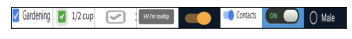

In [13]:
images, labels = next(iter(data_loader))

grid = torchvision.utils.make_grid(images)

show(grid)

### Model test run

In [33]:
model = torchvision.models.resnet18()
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 3)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
image, label = dataset[0]
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 256, 512])

In [39]:
output = model(image)

In [40]:
print(output)
print(torch.argmax(output), label)


tensor([[-0.1015,  0.4741, -0.7422]], grad_fn=<AddmmBackward0>)
tensor(1) 0
